Please upload the NIFTY 50 Excel file (e.g., 'NIFTY 50 - Yahoo Finance.xlsx')


Saving NIFTY 50 - Yahoo Finance.xlsx to NIFTY 50 - Yahoo Finance (2).xlsx
Successfully loaded 'NIFTY 50 - Yahoo Finance (2).xlsx'
Dropped 'Unnamed: 7' column

Invalid dates count: 28

Date range: 2020-02-12 00:00:00 to 2025-02-12 00:00:00

NaN counts after numeric conversion:
 Open         46
High          0
Low           0
Close         0
Adj Close     0
Volume       15
dtype: int64

Final cleaned shape: (1238, 6)
Final data (first 5 rows):
                 Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2020-02-12  12151.00  12231.75  12144.30  12201.20   12201.20  411700.0
2020-02-13  12219.55  12225.65  12139.80  12174.65   12174.65  501200.0
2020-02-14  12190.15  12246.70  12091.20  12113.45   12113.45  622800.0
2020-02-17  12131.80  12159.60  12037.00  12045.80   12045.80       NaN
2020-02-18  12028.25  12030.75  11908.05  11992.50   11992.50  676900.0

NaN counts after returns calculation:
 Open     

Dropdown(description='Risk Tolerance:', index=1, options=('Low', 'Medium', 'High'), value='Medium')

Dropdown(description='Horizon:', index=1, options=('Short-term (<1 year)', 'Medium-term (1-3 years)', 'Long-te…

Button(description='Get Recommendation', style=ButtonStyle())


=== NIFTY 50 Investment Recommendation ===
Risk Tolerance: High
Investment Horizon: Short-term (<1 year)

Risk Metrics:
- Annualized Volatility: 133.6182
- VaR (95%): -0.0172
- CVaR (95%): -0.1704
- Maximum Drawdown: -0.9913 on 2022-06-17 00:00:00
- Beta: 1.0000

Recommendation: Avoid
Reasoning:
- Extremely high volatility (>0.40) is notable even for high risk tolerance.
- Significant drawdown (>20%) is risky for short-term investors.
- High volatility (>0.25) may lead to unpredictable short-term outcomes.
- Too many risk factors exceed your tolerance or horizon.


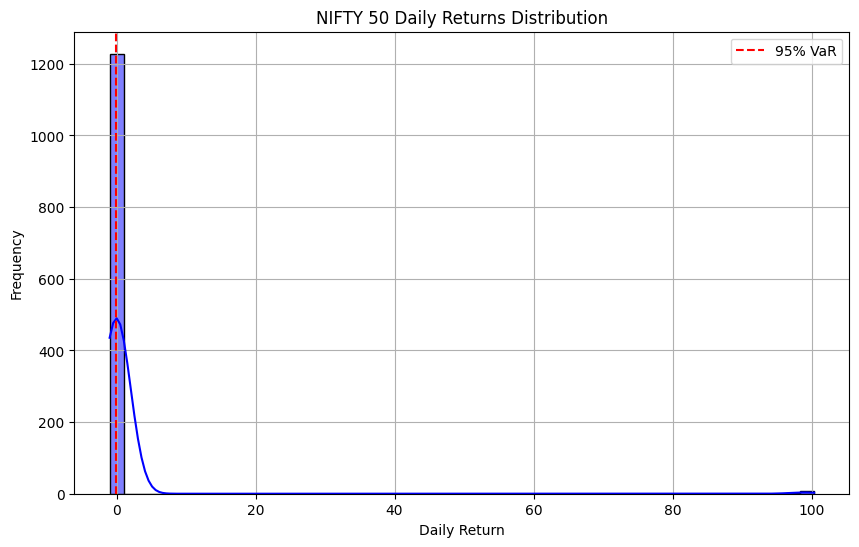

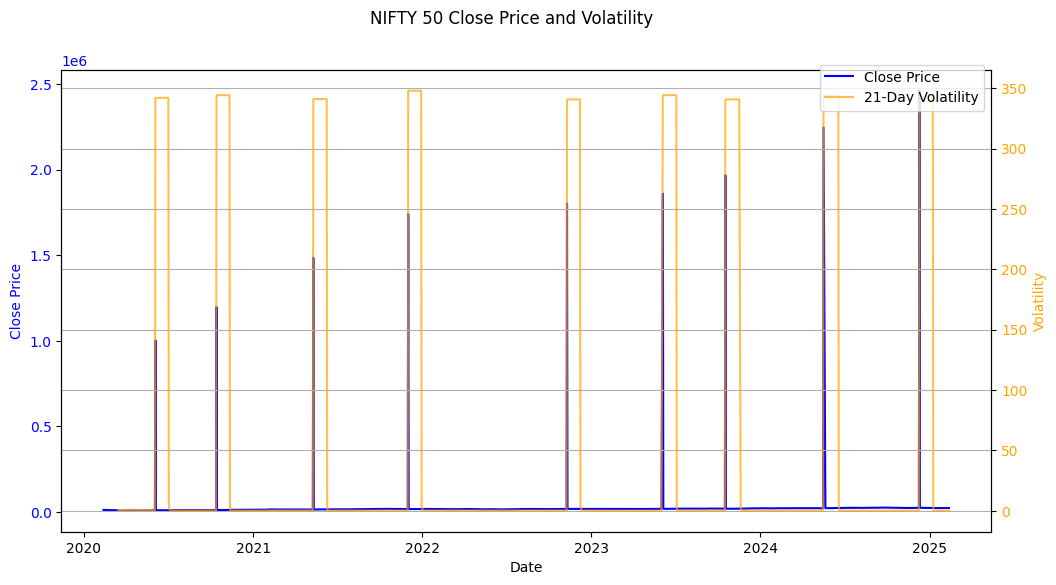

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Load data with upload prompt
print("Please upload the NIFTY 50 Excel file (e.g., 'NIFTY 50 - Yahoo Finance.xlsx')")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded. Please try again.")
file_name = list(uploaded.keys())[0]
try:
    df_raw = pd.read_excel(file_name)
    print(f"Successfully loaded '{file_name}'")
except Exception as e:
    raise ValueError(f"Failed to read '{file_name}'. Ensure it's a valid Excel file. Error: {str(e)}")

'''# Debug: Inspect raw data
print("Raw data shape:", df_raw.shape)
print("Raw columns:", df_raw.columns.tolist())'''

# Validate expected columns
if not {'Date', 'Close'}.issubset(df_raw.columns):
    raise ValueError(f"Data must contain 'Date' and 'Close' columns. Found: {df_raw.columns.tolist()}")

# Clean column names and drop useless columns
df_raw.columns = [str(col).strip() for col in df_raw.columns]
if 'Unnamed: 7' in df_raw.columns:
    df_raw = df_raw.drop(columns=['Unnamed: 7'])
    print("Dropped 'Unnamed: 7' column")

# Remove empty rows
df_raw = df_raw.dropna(how='all')
'''print("\nShape after removing empty rows:", df_raw.shape)'''

# Convert 'Date' column
def convert_date(date):
    try:
        if isinstance(date, (int, float)) and 40000 < date < 50000:
            return pd.to_datetime(date, unit='D', origin='1899-12-30')
        date_str = str(date).strip()
        if date_str == '' or date_str.lower() == 'nan':
            return pd.NaT
        date_str = date_str.replace('  ', ' ').replace('O t', 'Oct')
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

df_raw['Date'] = df_raw['Date'].apply(convert_date)
print("\nInvalid dates count:", df_raw['Date'].isna().sum())

# Drop invalid dates
df_raw = df_raw.dropna(subset=['Date'])

# Filter out future dates
current_date = pd.to_datetime('2025-04-16')
df_raw = df_raw[df_raw['Date'] <= current_date]
print("\nDate range:", df_raw['Date'].min(), "to", df_raw['Date'].max())

# Clean numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for col in numeric_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype(str).str.replace(' ', '', regex=False).replace('-', np.nan)
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Debug: Check NaNs
print("\nNaN counts after numeric conversion:\n", df_raw[numeric_cols].isna().sum())

# Filter valid 'Close' and drop duplicates
df = df_raw[df_raw['Close'].notna()].drop_duplicates(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
print("\nFinal cleaned shape:", df.shape)
print("Final data (first 5 rows):\n", df.head())
if df.empty or len(df) < 100:
    raise ValueError(f"Insufficient data after cleaning. Got {len(df)} rows, need at least 100.")

# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change()
df = df.dropna(subset=['Daily_Return'])
print("\nNaN counts after returns calculation:\n", df.isna().sum())

# Risk Assessment Metrics
trading_days = 252
# 1. Annualized Volatility
volatility = df['Daily_Return'].std() * np.sqrt(trading_days)

# 2. Value at Risk (VaR) and Conditional VaR (CVaR)
confidence_levels = [0.95, 0.99]
var_results = {}
cvar_results = {}
for cl in confidence_levels:
    var = np.percentile(df['Daily_Return'], 100 * (1 - cl))
    cvar = df['Daily_Return'][df['Daily_Return'] <= var].mean() if len(df['Daily_Return'][df['Daily_Return'] <= var]) > 0 else np.nan
    var_results[cl] = var
    cvar_results[cl] = cvar

# 3. Maximum Drawdown
cum_returns = (1 + df['Daily_Return']).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
max_drawdown_date = drawdown.idxmin()

# 4. Beta (NIFTY 50 as benchmark)
market_returns = df['Daily_Return']
asset_returns = df['Daily_Return']
cov_matrix = np.cov(asset_returns.dropna(), market_returns.dropna())
beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] != 0 else np.nan

# Interactive Decision Tool
def investment_decision(risk_tolerance, horizon):
    print("\n=== NIFTY 50 Investment Recommendation ===")
    print(f"Risk Tolerance: {risk_tolerance}")
    print(f"Investment Horizon: {horizon}")
    print("\nRisk Metrics:")
    print(f"- Annualized Volatility: {volatility:.4f}")
    print(f"- VaR (95%): {var_results[0.95]:.4f}")
    print(f"- CVaR (95%): {cvar_results[0.95]:.4f}")
    print(f"- Maximum Drawdown: {max_drawdown:.4f} on {max_drawdown_date}")
    print(f"- Beta: {beta:.4f}")

    # Decision Logic
    recommendation = ""
    reasoning = []

    # Risk Tolerance Thresholds
    if risk_tolerance == "Low":
        if volatility > 0.20:
            reasoning.append("High volatility (>0.20) exceeds low risk tolerance.")
        if var_results[0.95] < -0.03:
            reasoning.append("VaR at 95% (worse than -3%) is too risky for low tolerance.")
        if max_drawdown < -0.25:
            reasoning.append("Large drawdown (>25%) poses significant loss risk.")
    elif risk_tolerance == "Medium":
        if volatility > 0.30:
            reasoning.append("Very high volatility (>0.30) exceeds medium risk tolerance.")
        if var_results[0.95] < -0.05:
            reasoning.append("VaR at 95% (worse than -5%) is concerning.")
        if max_drawdown < -0.40:
            reasoning.append("Extreme drawdown (>40%) is risky.")
    else:  # High
        if volatility > 0.40:
            reasoning.append("Extremely high volatility (>0.40) is notable even for high risk tolerance.")
        if var_results[0.95] < -0.07:
            reasoning.append("VaR at 95% (worse than -7%) indicates severe potential losses.")

    # Horizon Considerations
    if horizon == "Short-term (<1 year)":
        if max_drawdown < -0.20:
            reasoning.append("Significant drawdown (>20%) is risky for short-term investors.")
        if volatility > 0.25:
            reasoning.append("High volatility (>0.25) may lead to unpredictable short-term outcomes.")
    elif horizon == "Medium-term (1-3 years)":
        if max_drawdown < -0.30:
            reasoning.append("Large drawdown (>30%) could impact medium-term goals.")
    else:  # Long-term
        reasoning.append("Long-term horizon mitigates short-term volatility and drawdowns.")

    # Recommendation
    if len(reasoning) > 2 or (risk_tolerance == "Low" and volatility > 0.20):
        recommendation = "Avoid"
        reasoning.append("Too many risk factors exceed your tolerance or horizon.")
    elif len(reasoning) == 1 or (risk_tolerance == "Medium" and volatility < 0.25):
        recommendation = "Hold"
        reasoning.append("Risks are moderate; consider market trends or diversification.")
    else:
        recommendation = "Invest"
        reasoning.append("Risk metrics align with your tolerance and horizon.")

    print("\nRecommendation:", recommendation)
    print("Reasoning:")
    for r in reasoning:
        print(f"- {r}")

    # Visualizations
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Daily_Return'], bins=50, kde=True, color='blue')
    plt.axvline(var_results[0.95], color='red', linestyle='--', label='95% VaR')
    plt.title('NIFTY 50 Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    rolling_vol = df['Daily_Return'].rolling(window=21).std() * np.sqrt(trading_days)
    ax2.plot(rolling_vol.index, rolling_vol, label='21-Day Volatility', color='orange', alpha=0.7)
    ax2.set_ylabel('Volatility', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    fig.suptitle('NIFTY 50 Close Price and Volatility')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.grid(True)
    plt.show()

# Interactive Widgets
risk_dropdown = widgets.Dropdown(
    options=["Low", "Medium", "High"],
    value="Medium",
    description="Risk Tolerance:",
)
horizon_dropdown = widgets.Dropdown(
    options=["Short-term (<1 year)", "Medium-term (1-3 years)", "Long-term (>3 years)"],
    value="Medium-term (1-3 years)",
    description="Horizon:",
)
submit_button = widgets.Button(description="Get Recommendation")

def on_submit(b):
    investment_decision(risk_dropdown.value, horizon_dropdown.value)

submit_button.on_click(on_submit)

# Display Interface
display(HTML("<h3>NIFTY 50 Investment Decision Tool</h3>"))
display(risk_dropdown)
display(horizon_dropdown)
display(submit_button)